## Super resolution

In [ ]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [ ]:
items = get_image_files(path_hr)

In [ ]:
def resize_one(fn, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [ ]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), items)

In [ ]:
bs,size=32,128
arch = resnet34

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y=lambda x: path_hr/x.name,
                   splitter=RandomSplitter())

In [ ]:
def get_dbunch(bs,size):
    dbunch = dblock.databunch(path_lr, bs=bs, path=path, item_tfms=Resize(size),
                              batch_tfms=[*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)])         
    dbunch.c = 3
    return dbunch

In [ ]:
dbunch = get_dbunch(bs,size)

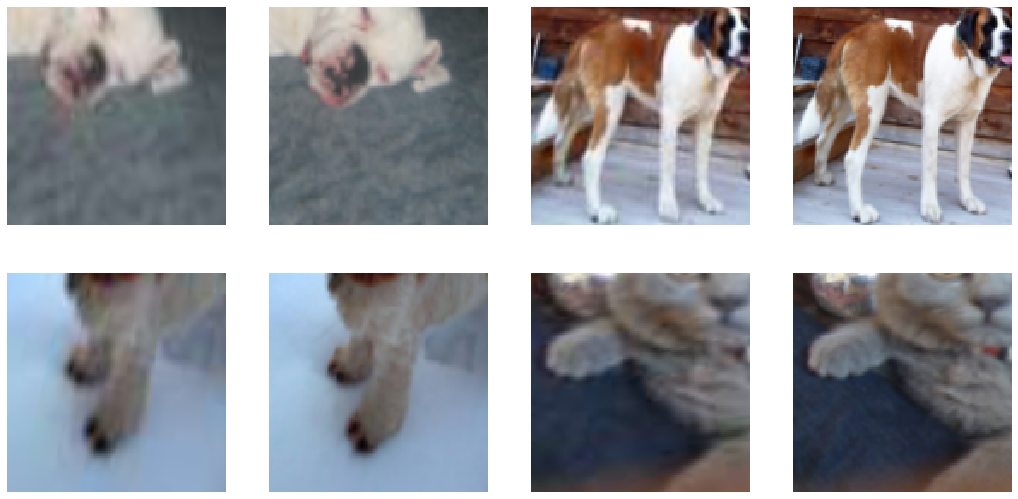

In [ ]:
dbunch.train_dl.show_batch(max_n=4, figsize=(18,9))

## Feature loss

In [ ]:
t = tensor(dbunch.valid_ds[0][1]).float().permute(2,0,1)/255.
t = torch.stack([t,t])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
t.shape

torch.Size([2, 3, 500, 385])

In [ ]:
gram_matrix(t)

tensor([[[0.0956, 0.0953, 0.0921],
         [0.0953, 0.0986, 0.0969],
         [0.0921, 0.0969, 0.0961]],

        [[0.0956, 0.0953, 0.0921],
         [0.0953, 0.0986, 0.0969],
         [0.0921, 0.0969, 0.0961]]])

In [ ]:
base_loss = F.l1_loss

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
vgg_m = vgg_m.requires_grad_(False)

In [ ]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target,reduction=reduction)]
        self.feat_losses += [base_loss(f_in, f_out,reduction=reduction)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out),reduction=reduction)*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        if reduction=='none': 
            self.feat_losses = [f.mean(dim=[1,2,3]) for f in self.feat_losses[:4]] + [f.mean(dim=[1,2]) for f in self.feat_losses[4:]]
        for n,l in zip(self.metric_names, self.feat_losses): setattr(self, n, l)
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [ ]:
learn = unet_learner(dbunch, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                     config=unet_config(blur=True, norm_type=NormType.Weight))

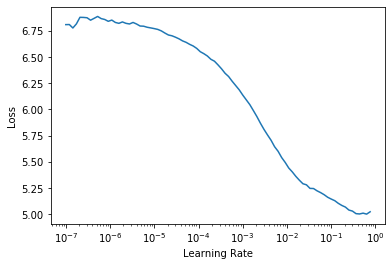

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3
wd = 1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start, wd=wd)
    learn.save(save_name)
    learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.807686,3.071174,0.097055,0.189418,0.262719,0.182015,0.478241,1.014225,0.847502,00:49
1,2.665750,2.966460,0.097507,0.186424,0.256145,0.176754,0.450392,0.977711,0.821528,00:49
2,2.660020,2.964151,0.097957,0.186474,0.254606,0.175271,0.460028,0.976287,0.813527,00:49
3,2.635785,2.890019,0.100960,0.184778,0.251589,0.171500,0.435668,0.951019,0.794506,00:49
4,2.573989,2.857131,0.093838,0.184257,0.249207,0.168691,0.433222,0.945968,0.781949,00:49
5,2.558148,2.796072,0.095902,0.182180,0.244857,0.164962,0.419814,0.923254,0.765104,00:49
6,2.524344,2.808264,0.096289,0.182468,0.244500,0.165527,0.425527,0.927101,0.766853,00:50
7,2.488260,2.773332,0.091110,0.180985,0.242599,0.163508,0.419790,0.916707,0.758634,00:50
8,2.473258,2.766009,0.093298,0.180337,0.241502,0.162666,0.418183,0.911741,0.758281,00:50
9,2.390463,2.669266,0.087503,0.178100,0.235890,0.157323,0.397681,0.883065,0.729703,00:50


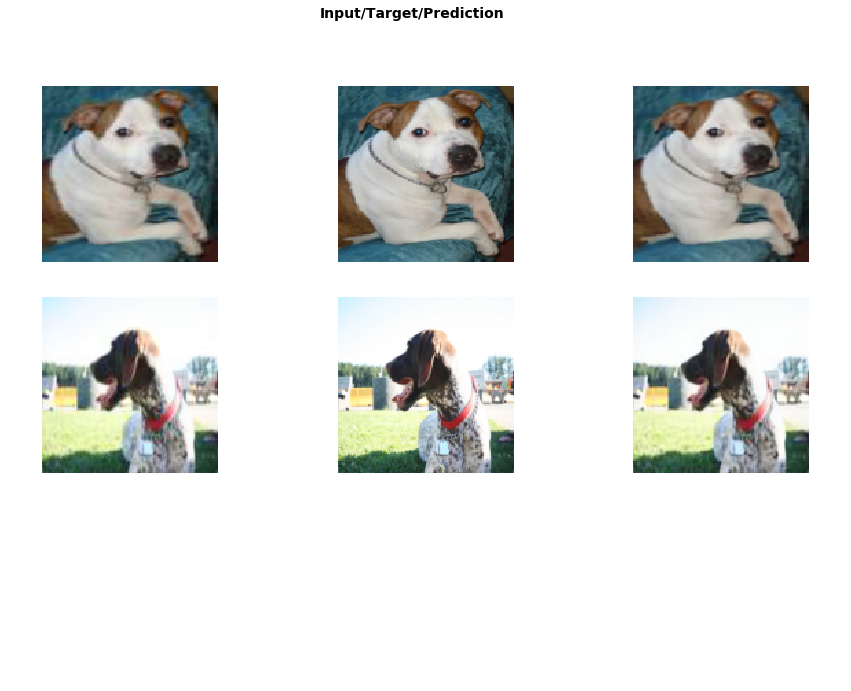

In [ ]:
do_fit('1a', slice(lr*10))

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.387386,2.664802,0.087450,0.177891,0.235427,0.156883,0.396345,0.882599,0.728207,00:53
1,2.369736,2.661796,0.087813,0.177854,0.235225,0.156755,0.393942,0.881185,0.729021,00:53
2,2.361443,2.655444,0.088093,0.177640,0.234576,0.156128,0.394707,0.878819,0.725482,00:53
3,2.370608,2.649884,0.087976,0.177562,0.234423,0.156131,0.392212,0.876441,0.725139,00:53
4,2.371687,2.650576,0.087767,0.176892,0.234101,0.156233,0.393337,0.876579,0.725667,00:52
5,2.365494,2.636572,0.087902,0.176884,0.233408,0.155001,0.390946,0.872486,0.719945,00:53
6,2.360668,2.629029,0.088252,0.176265,0.232575,0.154627,0.389362,0.869957,0.717991,00:53
7,2.354110,2.626665,0.087509,0.176913,0.232891,0.154590,0.387137,0.870162,0.717464,00:52
8,2.337545,2.620680,0.087147,0.176355,0.232121,0.154127,0.387733,0.868006,0.715189,00:53
9,2.323801,2.607643,0.087077,0.175836,0.231309,0.153475,0.383645,0.862762,0.713539,00:52


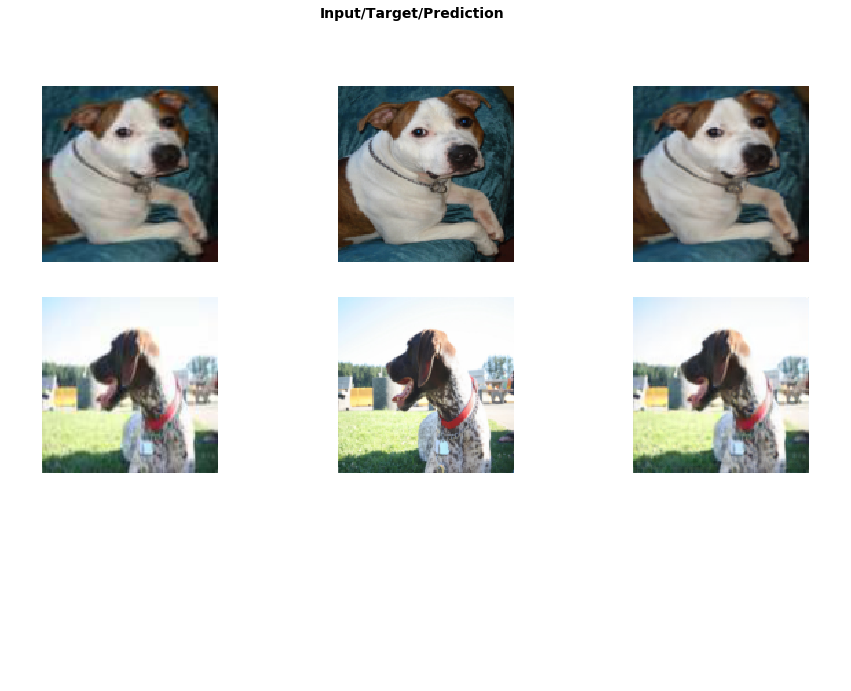

In [ ]:
do_fit('1b', slice(1e-5,lr))

In [ ]:
dbunch = get_dbunch(12,size*2)

In [ ]:
learn.dbunch = dbunch
learn.freeze()

In [ ]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.964742,2.097132,0.123021,0.241071,0.281122,0.142148,0.394413,0.567995,0.347363,03:23
1,1.946109,2.068474,0.122453,0.239844,0.277805,0.140109,0.386505,0.560967,0.340792,03:11
2,1.914131,2.039618,0.122197,0.240383,0.275555,0.139057,0.372839,0.553390,0.336198,03:11
3,1.911166,2.026438,0.122426,0.239035,0.273730,0.137567,0.369745,0.550393,0.333541,03:11
4,1.883506,2.013789,0.122188,0.238038,0.271950,0.136654,0.366809,0.547350,0.330801,03:11
5,1.874973,2.004433,0.123607,0.240344,0.272122,0.136426,0.357039,0.546027,0.328868,03:10
6,1.862156,1.986138,0.122783,0.237514,0.270469,0.135354,0.353579,0.539583,0.326856,03:10
7,1.840970,1.976038,0.122697,0.236627,0.268666,0.133960,0.352888,0.536989,0.324212,03:10
8,1.850380,1.960847,0.123162,0.238331,0.269243,0.134163,0.340418,0.532333,0.323196,03:11
9,1.811145,1.953522,0.121454,0.235828,0.266898,0.133187,0.344819,0.529998,0.321339,03:11


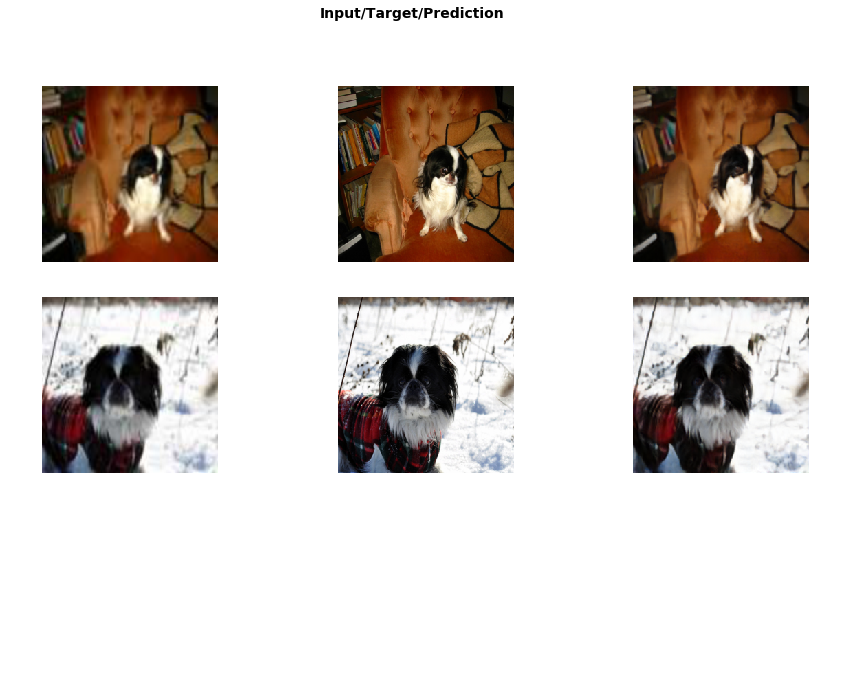

In [ ]:
do_fit('2a')

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.811166,1.955086,0.121748,0.236243,0.267111,0.133141,0.344675,0.530730,0.321437,03:16
1,1.812031,1.948622,0.121743,0.236032,0.266720,0.132933,0.341597,0.528780,0.320818,03:15
2,1.808005,1.946837,0.121508,0.236066,0.266534,0.132754,0.341944,0.527839,0.320193,03:15
3,1.793948,1.944550,0.120995,0.235804,0.266271,0.132559,0.341079,0.528130,0.319712,03:15
4,1.790866,1.940884,0.121425,0.235337,0.265840,0.132264,0.340940,0.525807,0.319270,03:15
5,1.800655,1.939362,0.122476,0.235712,0.265903,0.132172,0.339386,0.525267,0.318446,03:16
6,1.792633,1.936174,0.121747,0.236040,0.265983,0.132251,0.337234,0.524457,0.318462,03:16
7,1.793120,1.936935,0.121973,0.236428,0.266232,0.132240,0.336045,0.525347,0.318669,03:15
8,1.788742,1.937219,0.121609,0.235469,0.265734,0.132156,0.338405,0.525187,0.318660,03:15
9,1.799892,1.937056,0.121044,0.235462,0.265783,0.131961,0.338779,0.525887,0.318141,03:16


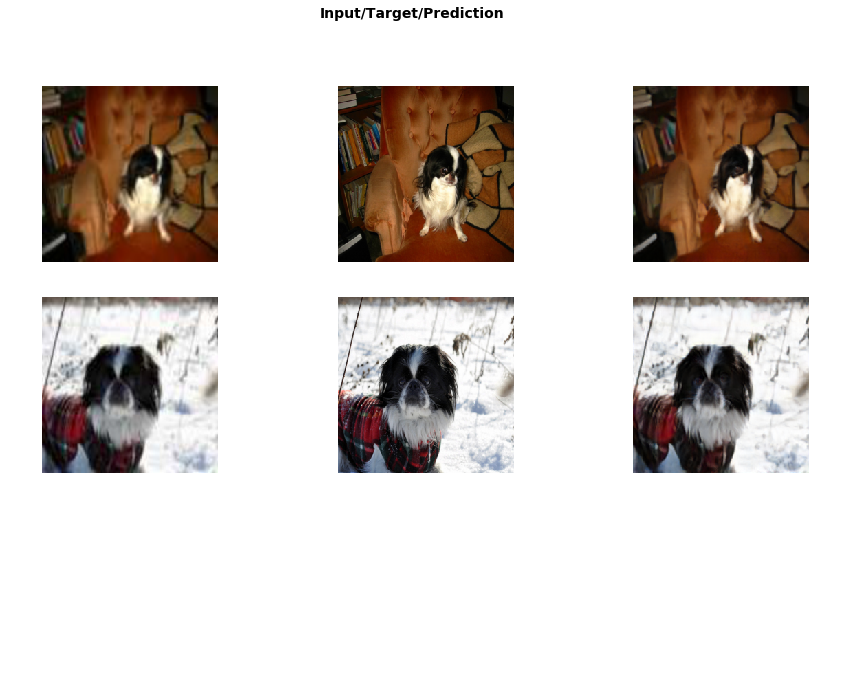

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [ ]:
learn = unet_learner(dbunch, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                     config=unet_config(blur=True, norm_type=NormType.Weight))

In [ ]:
class ResizeInfer(Transform):
    order=-20
    def encodes(self, img:PILImage):
        sz = (round_multiple(img.size[0],32),round_multiple(img.size[1],32))
        return img.resize(sz)

In [ ]:
dbunch_mr = dblock.databunch(path_mr, bs=1, val_bs=1, path=path, item_tfms=ResizeInfer(),
                             batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])         
dbunch_mr.c = 3

In [ ]:
learn.load('2b');

In [ ]:
learn.dbunch = dbunch_mr

In [ ]:
fn = dbunch_mr.valid_ds.items[0]; fn

PosixPath('/home/sgugger/.fastai/data/oxford-iiit-pet/small-256/staffordshire_bull_terrier_53.jpg')

In [ ]:
img = PILImage.create(fn); img.size

(384, 256)

In [ ]:
sz = (round_multiple(img.size[0],32),round_multiple(img.size[1],32))

In [ ]:
sz

(384, 256)

In [ ]:
img_hr,*_ = learn.predict(fn)

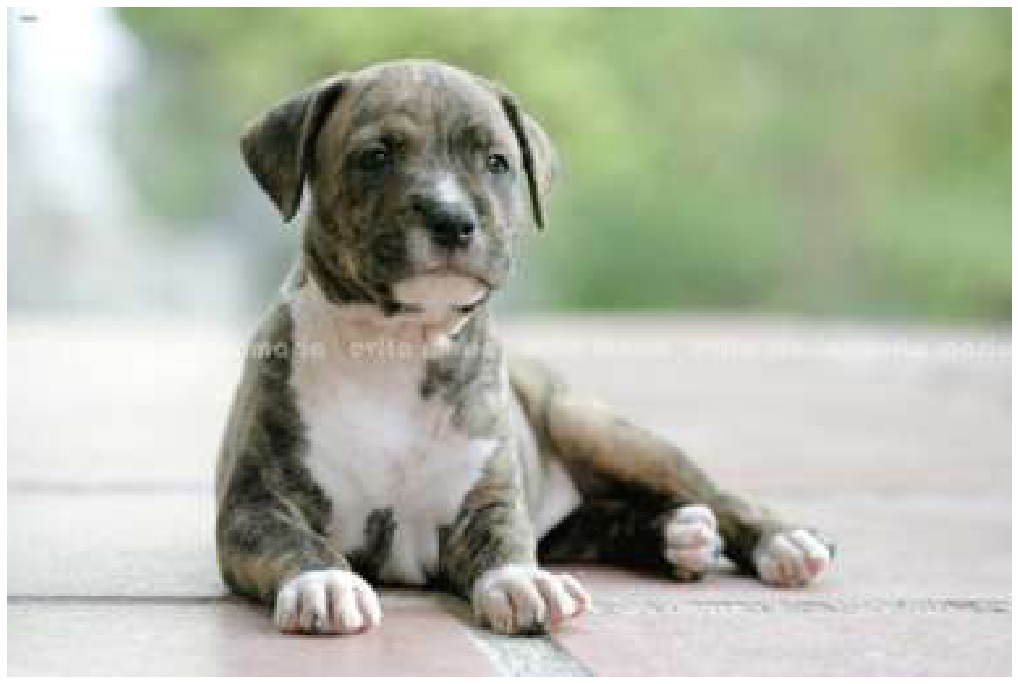

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

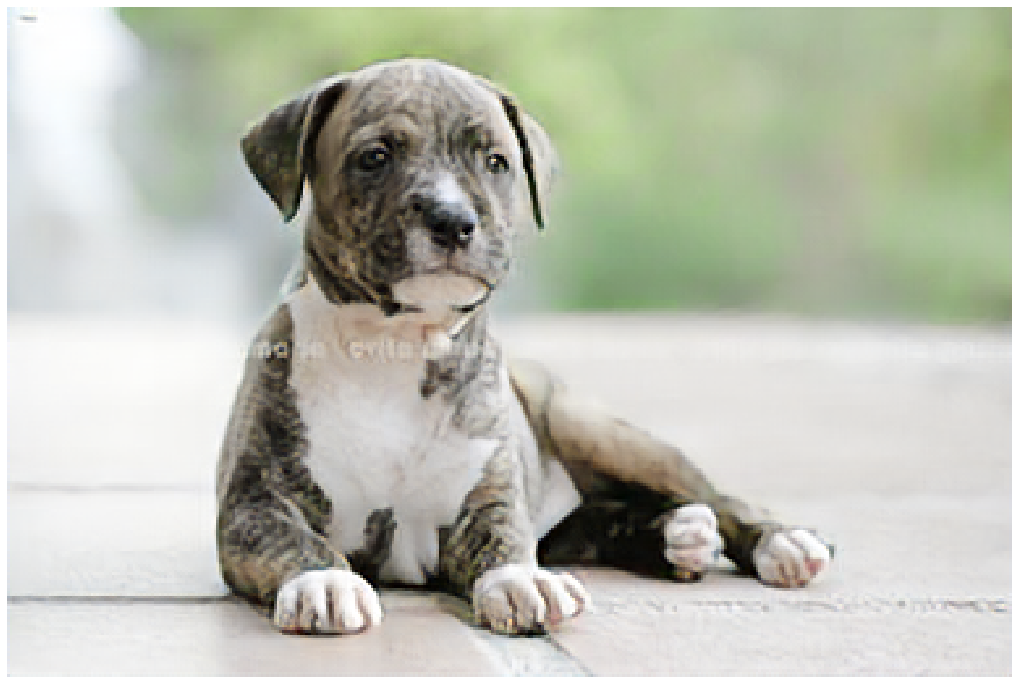

In [ ]:
show_image(img_hr, figsize=(18,15));